# Exercise 5 / Newton's Method

### Overview

1. Implement Newton's method
   - Use the provided backtracking line search

1. Compare Newton's method with first-order methods
   - Run Newton's method against gradient descent and Nesterov's accelerated gradient

1. Implement Hessian functions
   - Simple quadratic function: $f(x) = x_0^2 + 30x_1^2 + 4x_0$
   - Ill-conditioned quadratic: $f(x) = \frac{1}{2}x^T A x - b^T x$
   - Linear regression: $\min \frac{1}{n}\|Xw - y\|^2$
   - Logistic regression: $\min \frac{1}{n}\sum_i \log(1 + \exp(-y_i x_i^T w)) + \|w\|^2$

1. Analyze error plots of the respective optimization methods applied for different tasks
   - Observe the quadratic convergence of Newton's method


### Submission

When done, paste your code into the quiz on Moodle and answer the questions.

## Utilities

In [163]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from typing import Callable
from numpy.typing import NDArray
from sklearn.datasets import make_regression
from sklearn.datasets import make_classification
from scipy.optimize import minimize

In [164]:
def contour_map(
    f: Callable[[NDArray], float],
    xb: tuple[float, float] = (-1.0, 1.0),
    yb: tuple[float, float] = (-1.0, 1.0),
    ax=None,
) -> None:
    """Plots the contour lines of a scalar function on a 2D grid.

    Args:
        f (Callable[[NDArray], float]): Scalar function mapping points to values.
        xb (tuple[float, float], optional): Lower and upper bounds for the x-axis. Defaults to (-1.0, 1.0).
        yb (tuple[float, float], optional): Lower and upper bounds for the y-axis. Defaults to (-1.0, 1.0).
        ax (optional): The axes to plot on. Defaults to None.
    """
    if ax is None:
        ax = plt
    (nx, ny) = (45, 45)
    x = np.linspace(*xb, nx)
    y = np.linspace(*yb, ny)
    xv, yv = np.meshgrid(x, y)
    grid = np.block([[xv.reshape(1, -1)], [yv.reshape(1, -1)]]).T
    values = np.fromiter((f(point) for point in grid), dtype=np.double)
    ax.contour(xv, yv, values.reshape(nx, ny), 15)


def surface_plot(
    f: Callable[[NDArray], float],
    xb: tuple[float, float] = (-1.0, 1.0),
    yb: tuple[float, float] = (-1.0, 1.0),
) -> tuple[plt.Figure, Axes3D]:
    """Creates a 3D surface plot of a scalar function on a 2D grid.

    Args:
        f (Callable[[NDArray], float]): Scalar function mapping points to values.
        xb (tuple[float, float], optional): Lower and upper bounds for the x-axis. Defaults to (-1.0, 1.0).
        yb (tuple[float, float], optional): Lower and upper bounds for the y-axis. Defaults to (-1.0, 1.0).
    Returns:
        tuple[plt.Figure, Axes3D]: Figure and axis containing the rendered surface.
    """
    (nx, ny) = (45, 45)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    x = np.linspace(*xb, nx)
    y = np.linspace(*yb, ny)
    xv, yv = np.meshgrid(x, y)
    grid = np.block([[xv.reshape(1, -1)], [yv.reshape(1, -1)]]).T
    values = np.fromiter((f(point) for point in grid), dtype=np.double)
    ax.plot_surface(xv, yv, values.reshape(nx, ny), cmap=cm.coolwarm)
    return fig, ax

In [165]:
def backtracking_line_search(
    x: NDArray,
    d: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    alpha: float = 0.3,
    beta: float = 0.8,
) -> float:
    """Performs Armijo backtracking line search for a descent direction.

    Args:
        x (NDArray): Current point in parameter space.
        d (NDArray): Candidate descent direction.
        f (Callable[[NDArray], float]): Objective function producing scalar values.
        g (Callable[[NDArray], NDArray]): Gradient of the objective function.
        alpha (float, optional): Armijo sufficient decrease parameter. Defaults to 0.3.
        beta (float, optional): Multiplicative shrink factor for the step size. Defaults to 0.8.
    Returns:
        float: Step length that satisfies the Armijo condition.
    """
    step_size = 1.0
    fx = f(x)
    grad_x = g(x)
    directional_derivative = grad_x.dot(d)

    while f(x + step_size * d) > fx + alpha * step_size * directional_derivative:
        prev_step_size = step_size
        step_size *= beta
        if prev_step_size == step_size: break # If the floating point numbers are equal, we have reached the machine precision limits.

    return step_size


def non_descent_backtracking_line_search(
    x: NDArray,
    d: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    alpha: float = 1.0,
    beta: float = 0.8,
) -> float:
    """Line search for methods that do not guarantee a descent direction.
    Finds a step size that satisfies a modified sufficient decrease condition.

    Args:
        x (NDArray): The current point.
        d (NDArray): The search direction (not necessarily a descent direction).
        f (Callable[[NDArray], float]): The objective function.
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        alpha (float, optional): The parameter of the modified sufficient decrease condition. Defaults to 0.3.
        beta (float, optional): The factor by which to reduce the step size per iteration. Defaults to 0.8.

    Returns:
        float: The step size that satisfies the modified sufficient decrease condition.
    """
    step_size = 1.0
    fx: float = f(x)
    grad_x = g(x)
    directional_derivative = grad_x.dot(d)
    while (
        f(x + step_size * d)
        > fx + alpha * step_size * directional_derivative + step_size / 2 * d.T @ d
    ):
        prev_step_size = step_size
        step_size *= beta
        if prev_step_size == step_size: break # If the floating point numbers are equal, we have reached the machine precision limits.

    return step_size

In [166]:
def gradient_descent_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Collects iterates produced by gradient descent.

    Args:
        x0 (NDArray): Initial point used to seed the algorithm.
        f (Callable[[NDArray], float]): Objective function producing scalar values.
        g (Callable[[NDArray], NDArray]): Gradient of the objective function.
        max_iter (int, optional): Maximum number of gradient steps. Defaults to 100.
    Returns:
        list[NDArray]: Sequence of iterates, including the initial point.
    """
    x = np.array(x0, dtype=float, copy=True)
    xs = [x.copy()]
    for _ in range(max_iter):
        grad = g(x)
        step = backtracking_line_search(x, -grad, f, g)
        x = x - step * grad
        xs.append(x.copy())
    return xs


def heavy_ball_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs the Heavy Ball method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        max_iter (int, optional): The maximum number of steps. Defaults to 100.

    Returns:
        list[NDArray]: The list of points visited during the optimization.
    """
    x = np.array(x0, dtype=float, copy=True)
    xs = [x]
    for i in range(1, max_iter + 1):
        current_x = xs[-1]
        prev_x = xs[-2] if len(xs) > 1 else xs[-1]
        d = -g(current_x) + (i - 1) / (i + 1) * (current_x - prev_x)
        t = non_descent_backtracking_line_search(current_x, d, f, g)
        xs.append(current_x + t * d)

    return xs


def nag_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs Nesterov's accelerated gradient method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        max_iter (int, optional): The maximum number of steps. Defaults to 100.

    Returns:
        list[NDArray]: The list of points visited during the optimization.
    """
    x = np.array(x0, dtype=float, copy=True)
    xs = [x]
    for i in range(1, max_iter + 1, 1):
        current_x = xs[-1]
        prev_x = xs[-2] if len(xs) > 1 else xs[-1]
        y = current_x + (i - 1) / (i + 2) * (current_x - prev_x)
        d = g(y)
        t = non_descent_backtracking_line_search(y, -d, f, g)
        xs.append(y - t * d)

    return xs

In [167]:
EXAMPLE_MATRIX = np.array([[30.0, 15], [-20, 25]]) / 20

EXAMPLES = [
    (
        lambda x: x.T @ EXAMPLE_MATRIX @ x + 1,
        lambda x: (EXAMPLE_MATRIX + EXAMPLE_MATRIX.T) @ x,
        lambda x: (EXAMPLE_MATRIX + EXAMPLE_MATRIX.T),
        0.5 * np.ones(2),
        (-1.0, 1.0),
        (-1.0, 1.0),
    ),
    (
        lambda x: (x[0] ** 2 + 30 * x[1] ** 2 + 4 * x[0]),
        lambda x: np.array([2 * x[0] + 4, 60 * x[1]]),
        lambda x: np.array([[2, 0], [0, 60]]),
        np.array([2.0, 3.0]),
        (-2.5, 2.5),
        (-1.5, 3.5),
    ),
    (
        lambda x: np.linalg.norm(np.sin(x * 3)) ** 2,
        lambda x: 6 * np.sin(x * 3) * np.cos(x * 3),
        lambda x: 18 * np.diag(2 * np.cos(3 * x) ** 2 - 1),
        np.array([0.2, 0.15]),
        (-0.5, 0.5),
        (-0.5, 0.5),
    ),
]


def run_examples(
    optimizer_1: Callable,
    optimizer_name_1: str,
    optimizer_2: Callable,
    optimizer_name_2: str,
    uses_hessian_1: bool = False,
    uses_hessian_2: bool = False,
) -> None:
    """Compares one optimizer to another one.

    Args:
        optimizer_1 (Callable): The optimizer to test.
        optimizer_name_1 (str): Name of the first optimizer.
        optimizer_2: optimizer_path_function_type): The second optimizer to compare against.
        optimizer_name_2 (str): Name of the second optimizer.
        uses_hessian_1 (bool, optional): Whether the first optimizer uses the Hessian function. Defaults to False.
        uses_hessian_2 (bool, optional): Whether the second optimizer uses the Hessian function. Defaults to False.
    """
    for f, g, h, x0, x_bounds, y_bounds in EXAMPLES:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

        xs_1 = np.array(
            optimizer_1(x0, f, g, h) if uses_hessian_1 else optimizer_1(x0, f, g)
        )
        xs_2 = np.array(
            optimizer_2(x0, f, g, h) if uses_hessian_2 else optimizer_2(x0, f, g)
        )

        contour_map(f, xb=x_bounds, yb=y_bounds, ax=axs[0])

        axs[0].plot(xs_1[:, 0], xs_1[:, 1], ".--k", label=optimizer_name_1)
        axs[0].plot(
            xs_2[:, 0],
            xs_2[:, 1],
            ".--",
            color="gray",
            alpha=0.5,
            label=optimizer_name_2,
        )

        axs[1].semilogy(
            np.arange(0, len(xs_1)), [f(x) for x in xs_1], label=optimizer_name_1
        )
        axs[1].semilogy(
            np.arange(0, len(xs_2)), [f(x) for x in xs_2], label=optimizer_name_2
        )

        axs[0].legend()
        axs[1].legend()
        axs[1].set_xlabel("iteration")
        axs[1].set_ylabel("f(x_t)")

        plt.show()

## Task 1: Newton's method

Implement Newton's method using the above provided backtracking line search.
* `x0` is the initial point.
* `f` is the function you are trying to minimize.
* `g` is the gradient of `f`.
* `h` is the hessian of `f`.

Function `newtons_method_path` should return a list of vectors on the path to the minimum.

In [228]:
def newtons_path(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    h: Callable[[NDArray], NDArray],
    max_iter: int = 100,
) -> list[NDArray]:
    """Performs Newton's method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        h (Callable[[NDArray], NDArray]): The second gradient of the objective function.
        max_iter (int, optional): The maximum number of steps. Defaults to 100.

    Returns:
        list[NDArray]: The list of points visited during the optimization.
    """
    # TODO: Implement Newton's method using the provided backtracking line search
    # raise NotImplementedError
    eps = 0.000000001
    x = np.array(x0, dtype=float, copy=True)
    xs = [x.copy()]
    for i in range(max_iter):
        # x -= g(x) / h(x)
        d = np.linalg.solve(h(x) + eps*np.eye(h(x).shape[0]), -g(x))
        # d = np.linalg.solve(h(x), -g(x))
        # x += backtracking_line_search(x, d, f, g) * d
        bls = backtracking_line_search(x, d, f, g)
        # print(i, bls, d)
        print('h', h(x).shape)
        print('g', g(x).shape)
        x += bls * d
        xs.append(x.copy())
    return xs

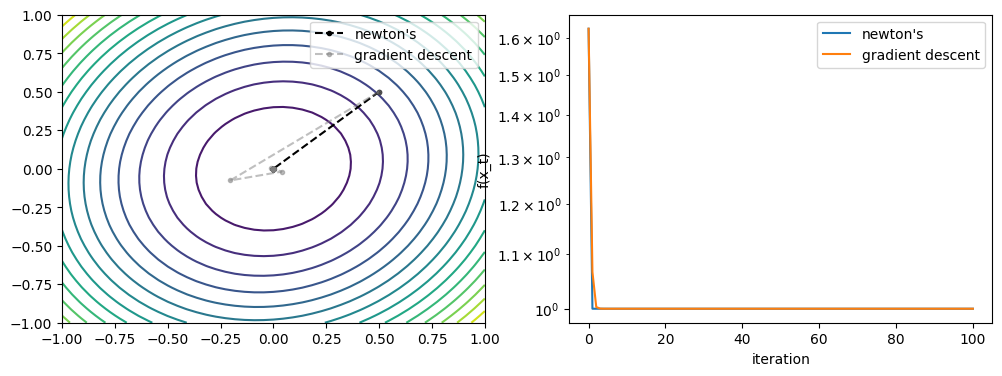

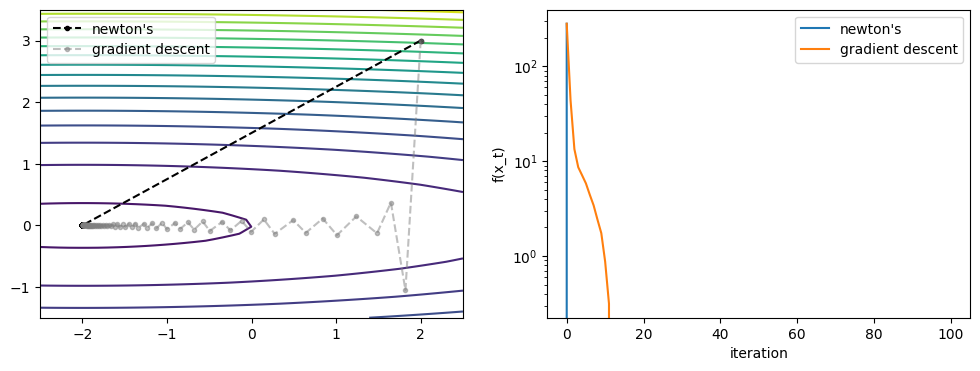

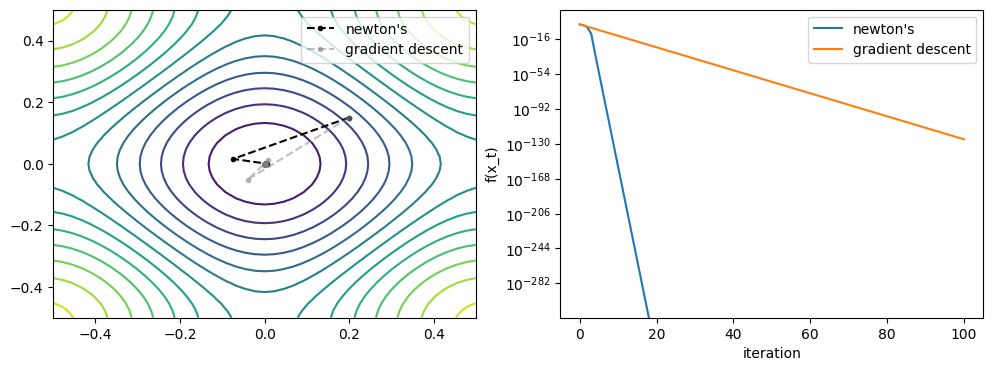

In [169]:
run_examples(
    optimizer_1=newtons_path,
    optimizer_name_1="newton's",
    optimizer_2=gradient_descent_path,
    optimizer_name_2="gradient descent",
    uses_hessian_1=True,
)

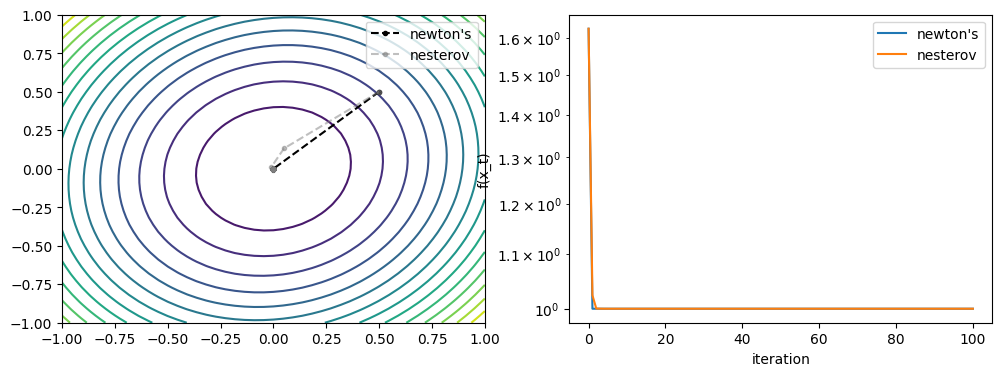

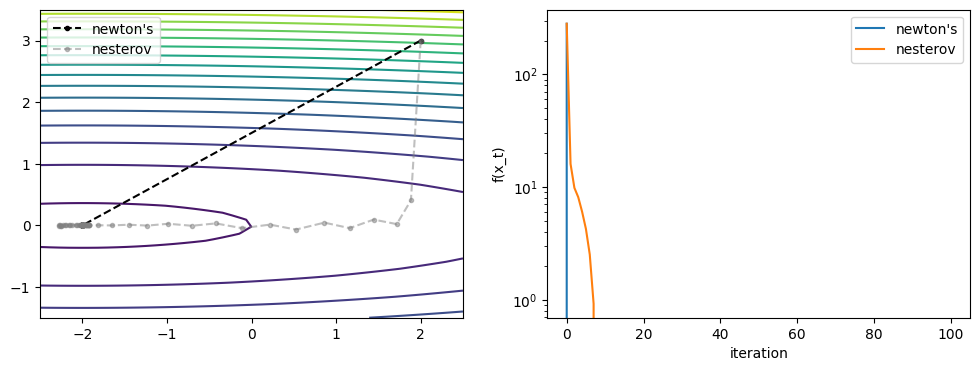

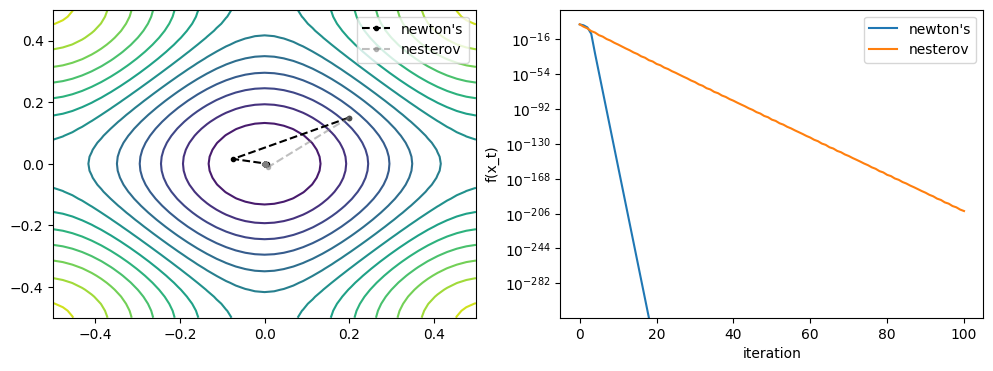

In [170]:
run_examples(
    optimizer_1=newtons_path,
    optimizer_name_1="newton's",
    optimizer_2=nag_path,
    optimizer_name_2="nesterov",
    uses_hessian_1=True,
)

## Task 2: Error plots

Complete the hessians of the following functions.
Then compare and plot the error over time for the four methods on the following tasks.
Implementations of the prior methods are given in the Utils section.

In [171]:
def plot_error(
    x0: NDArray,
    f: Callable[[NDArray], float],
    g: Callable[[NDArray], NDArray],
    h: Callable[[NDArray], NDArray],
    x_star: NDArray,
) -> None:
    """Compares the difference between optimum and function value along the paths of gradient descent, heavy ball and Nesterov's method.

    Args:
        x0 (NDArray): The starting point.
        f (Callable[[NDArray], float]): The objective function.
        g (Callable[[NDArray], NDArray]): The gradient of the objective function.
        x_star (NDArray): The optimal solution.
    """
    ball = heavy_ball_path(x0, f, g)
    nest = nag_path(x0, f, g)
    gd = gradient_descent_path(x0, f, g)
    newt = newtons_path(x0, f, g, h)

    def errors(path: list[NDArray]) -> NDArray:
        return np.array([f(x) for x in path]) - f(x_star)

    plt.semilogy(
        np.arange(len(gd)),
        errors(gd),
        label="gradient descent",
    )
    plt.semilogy(
        np.arange(len(ball)),
        errors(ball),
        label="heavy ball",
    )
    plt.semilogy(
        np.arange(len(nest)),
        errors(nest),
        label="nesterov",
    )
    plt.semilogy(
        np.arange(len(newt)),
        errors(newt),
        label="newton's",
    )

    plt.legend()
    plt.show()

### Simple quadratic function

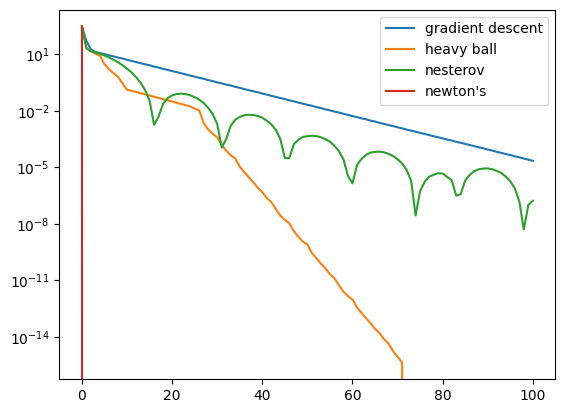

In [172]:
def f(x):
    return x[0] ** 2 + 30 * x[1] ** 2 + 4 * x[0]


def g(x):
    return np.array([2 * x[0] + 4, 60 * x[1]])


def h(x):
    # TODO: Implement the Hessian function
    # raise NotImplementedError
    return np.diag([2, 60])


x0 = np.array([2.0, 3.0])
x_star = np.array([-2.0, 0.0])

plot_error(x0, f, g, h, x_star)

### Ill-conditioned quadratic

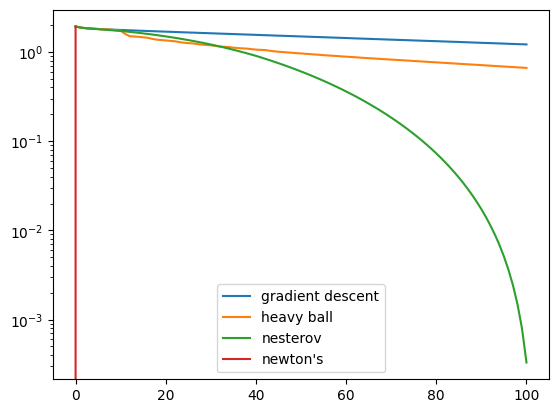

In [173]:
n = 50
rng = np.random.default_rng(seed=42)
Q = rng.standard_normal((n, n))
Q = Q.T @ Q
U, _ = np.linalg.qr(Q)

A = U @ np.diag(np.linspace(1, 1000, n)) @ U.T
b = rng.standard_normal(n)


def f(x):
    return 0.5 * x.T @ A @ x - b.T @ x


def g(x):
    return A @ x - b


def h(x):
    # TODO: Implement the Hessian function
    # raise NotImplementedError
    return A


x0 = np.zeros(n)
x_star = np.linalg.solve(A, b)

plot_error(x0, f, g, h, x_star)

### Linear regression

h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 100)
g (100,)
h (100, 10

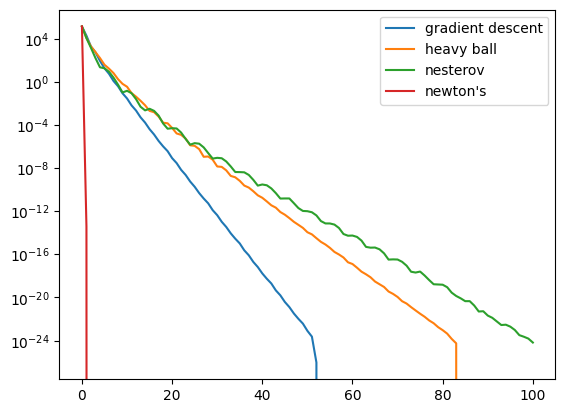

In [229]:
def f(w):
    return np.linalg.norm(X @ w - y) ** 2 / len(X)


def g(w):
    return 2 * X.T @ (X @ w - y) / len(X)


def h(w):
    # TODO: Implement the Hessian function
    # raise NotImplementedError
    return 2 * X.T @ X / len(X)


X, y = make_regression(n_samples=1000, n_features=100, n_informative=40, random_state=0)
x0 = np.zeros(100)

x_star = np.linalg.lstsq(X, y, rcond=None)[0]

plot_error(x0, f, g, h, x_star)

### Logistic regression


In [241]:
def h(w):
    n = X.shape[0]
    d = X.shape[1]
    
    # 1. Calculate the argument for the exponent
    # Note: The specific formula depends on how f(x) was written. 
    # Based on your f(w) and g(w), the exponent term is exp(-y * X.dot(w))
    
    z = -y * (X @ w)
    sig = 1.0 / (1.0 + np.exp(-z)) # Sigmoid
    
    # The diagonal weights for logistic regression Hessian are p * (1-p)
    # Since y is just a sign flip, p*(1-p) remains the same regardless of y's sign in the derivative chain
    weights = sig * (1.0 - sig)
    
    # 2. Calculate X.T @ D @ X efficiently using broadcasting
    # We multiply weights into X before the dot product to avoid creating a huge diagonal matrix D
    # Formula: (1/n) * X.T @ diag(weights) @ X
    
    data_term = (X.T * weights) @ X / n
    
    # 3. Regularization term (from ||w||^2)
    # The derivative of w^2 is 2w, the derivative of that is 2.
    reg_term = 2 * np.eye(d)
    
    return data_term + reg_term

In [246]:
def h(w):
    """
    Hessian (Second Derivative)
    Formula: (1/N) * X.T * S * X + 2*I
    """
    N, D = X.shape
    
    # 1. Compute the exponent term: exp(-y * x.w)
    sig = np.exp(-y * X.dot(w))
    
    # 2. Compute the diagonal weights s_i
    # s_i = sig / (1 + sig)^2
    # Shape: (N,)
    s = sig / ((1.0 + sig) ** 2)
    
    # 3. Compute X.T * S * X
    # We calculate (S * X) first. To do this correctly without a huge diagonal matrix:
    # Reshape s to (N, 1) to scale each ROW of X (element-wise broadcasting over columns).
    # Result: (N, D), where each row i is x_i scaled by s_i
    SX = s[:, np.newaxis] * X
    
    # Now perform the matrix multiplication X.T @ (S * X)
    # Shape: (D, N) @ (N, D) -> (D, D)
    hessian_loss = X.T.dot(SX) / N
    
    # 4. Add Regularization term (2nd derivative of ||w||^2 is 2*I)
    hessian_reg = 2 * np.eye(D)
    
    return hessian_loss + hessian_reg

In [ ]:
def h(w):
    sig = np.exp(-y * X.dot(w)) # (1000,)
    ff = 0
    gg = ff + 1
    return 2 * np.eye(X.shape[1]) - X.T.dot(y * ((ff * gg - ff ** 2) / gg ** 2)) / X.shape[0]    

In [248]:
def h(w):
    n, d = X.shape
    z = y * (X @ w)                  # elementwise
    sig = np.exp(-z)
    a = sig / (sig + 1.0)            # a_i = 1 / (1 + exp(z_i))
    r = a * (1.0 - a) * (y ** 2)     # handles y in {0,1} or {-1,1}
    # X.T @ (X * r[:, None]) is X^T D X where D = diag(r)
    return 2.0 * np.eye(d) + (X.T @ (X * r[:, None])) / n

In [ ]:
def h(w):
    sig = np.exp(-y * (X @ w))
    a = sig / (sig + 1.0)
    r = a * (1.0 - a) * (y ** 2)
    return 2.0 * np.eye(X.shape[1]) + (X.T @ (X * r[:, None])) / X.shape[0]

(80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80, 80)
g (80,)
h (80,

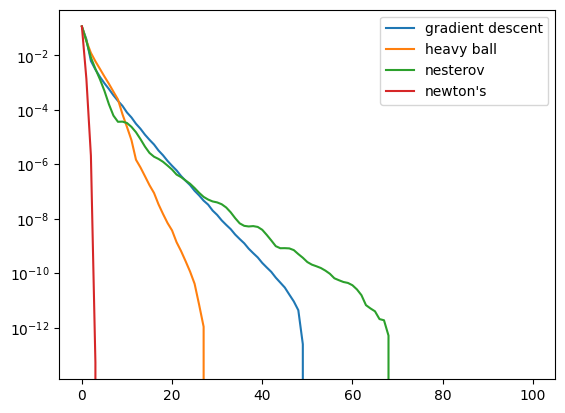

In [249]:
def f(w):
    return np.log(1.0 + np.exp(-y * X.dot(w))).mean() + np.linalg.norm(w) ** 2


def g(w):
    sig = np.exp(-y * X.dot(w)) # (1000,)
    # (sig * y / (sig + 1.0)) (1000,)
    return 2 * w - X.T.dot(sig * y / (sig + 1.0)) / X.shape[0] # (80,)


def hh(w):
    # TODO: Implement the Hessian function
    # raise NotImplementedError
    # z = -y * (X @ w)
    # sig = 1.0 / (1.0 + np.exp(-z)) # Sigmoid
    sig = np.exp(-y * X.dot(w)) # (1000,)
    # print(X.T.dot(sig).T.shape)
    ff = -y
    print('ff', ff.shape)
    xw = X.dot(np.eye(w.shape[0],1))
    print('xw', xw.shape)
    ff = ff * xw
    print('ff', ff.shape)
    ff *= sig
    print('ff', ff.shape)
    # ff = -y * X.dot(np.eye(w.shape[0])) * sig
    # ff = np.outer(-y, X.T.dot(sig))
    ff = -y * X.T.dot(sig)
    print('trtr', X.T.dot(sig).shape)
    print('trtr2', np.outer(-y, X.T.dot(sig)).shape)

    # ff = - (X.T.dot(sig).T) @ y
    # ff = -y * (X.T.dot(np.exp(-y * X.dot(w))).T)
    print(ff.shape)
    gg = ff + 1
    # return 2 * np.eye(X.shape[1]) + (X.T * (sig * (1.0 - sig))) @ X / X.shape[0]
    # return 2 * np.eye(X.shape[1]) + X.T.dot( (ff * gg - ff ** 2) / gg ** 2)  / X.shape[0]
    # return 2 * np.eye(X.shape[1]) + X.T.dot(y * (ff * gg - ff ** 2) / gg ** 2) / X.shape[0]
    return 2 * np.eye(X.shape[1]) - X.T.dot(y * ((ff * gg - ff ** 2) / gg ** 2)) / X.shape[0]


X, y = make_classification(
    1000,
    80,
    n_informative=40,
    #                               n_redundant=0,
    n_clusters_per_class=2,
    flip_y=0.1,
    random_state=0,
)

x0 = np.zeros(80)
print(x0.shape)
x_star = minimize(f, x0, jac=g).x

plot_error(x0, f, g, h, x_star)

In [243]:
np.eye(X.shape[1]).shape

(80, 80)